###Question and Goals
The high level question I wish to answer is how does an IPO's first 9 months affect stock price performance for months 9 through 12? My goal is to identify a stock that will yield >15% returns in months 9 through 12, with precision greater than 50%. I will explain how the data was cleaned, what assumptions were made in building out the data set, visualizations in the data that are of interest, and then synthesize this with fundamental machine learning concepts. The reason for >50% precision is this would imply I am correctly predicting stocks that return >15% at least 50% of the time. I am less concerned with accuracy, as I do not need to identify EVERY successful IPO to have good investment prospects. This tool would not make an entire investment firm, but simply could be one of many tools to help build out and diversify and investment portfolio. I simply wish to identify which investment prospects will yield positive returns at least 50% of the time. This is not fool proof, as one could successfully identify multiple IPO's with 15% returns, but wrongly identify an IPO that ends up halving in value resulting in a net loss on investment. Later we will see that the distribution of returns are evenly distributed around 0, and thus we will assume that over time, precision >50% will ultimately yield positive returns for an investor.
###Cleaning
####Market Data
Originally the data set was a 3672x1664 matrix, consisting of 260 days’ worth of trading information, and hundreds of categorical elements. Much of the information was sparse, so a reordering of the columns was in order to preserve and order the opening and closing price of each day, along with the trading volume by day. The daily highs and lows were sparse, so those columns were ultimately dropped to prevent dropping rows unnecessarily later on. In order to have one metric for understanding the stock prices, I had to create hundreds of new columns capturing the % change in price from initial IPO price to day X, X being an element of [0,260].
####Prior Year Performance
Once I had a picture of how the stock prices had changed since opening day, I was able to start working on the categorical elements. Hundreds of the columns referred to various financial metrics for the year prior to the IPO of the company. I did some research, and found that this information comes from an S1 filing, which is required for any company going public, however much of the information included in the S1 is optional. I obtained through Pitchbook a list of the S1’s for almost all the IPO’s in my data set. However, information was still missing, and I found many of these columns would be sparse even if I automatically filled out the dataset from the S1 filings. Because of this, all of the features regarding the year prior’s financial information were dropped (however this leaves a good opportunity for one to expand this model if that information could be filled out).
####Categorical Data
What I was left to choose from was a variety of categorical data. I ultimately decided on the most filled out 15 columns regarding information about the CEO, the sector of the business, the location of the company, etc. I also had the net income of businesses, and the revenue of the businesses in the first 9 months. Thus, I created a column, “Net Income to Revenue Ratio,” to understand the margins of the businesses in question. I used excel tools to format the numbers, so they weren’t showing up as strings, and made sure to eliminate unnecessary characters from the columns (similar to regular expressions but simpler). Further, I generalized company location to US or Other, to fundamentally understand if there was a correlation between US or non US based companies and to simplify the model, and populated with 0’as and 1’s. Further I used excel tools to group the company sectors into 10 fundamental groups, and changed the groups to numerical values 0 through 9. I made the rest of the values numerical in nature.
####Assumptions
I then had to decide if I would populate the model with any sort of pseudo-data to prevent dropping unnecessary rows later on. Within the CEO gender column, I simply looked at the percentage of males and females in the data I had, and randomly filled the gaps according to that binomial probability. I did a similar process with the US or Other column. As far as any information regarding revenue, net income, market cap, number of employees, etc, I decided that this financial information could not be altered by assumption for fear of messing up the model, and ultimately decided to drop those rows with missing information. I also made the “1 year mark” day 254 instead of 260 because many companies were missing data for the last 5-6 days of the year in market performance information.

Import neccesary libraries.

In [ ]:
#@title
#Import necessary libraries
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import os
import string
import matplotlib.pyplot as plt
from math import log
from scipy import sparse
from sklearn import datasets
from scipy import linalg as la
from collections import Counter
from matplotlib import pyplot as plt
from scipy.sparse import linalg as spla
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn import decomposition
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pandas as pd
from scipy.stats import gaussian_kde
import sklearn
from sklearn import linear_model
from sklearn.inspection import permutation_importance
from sklearn.cluster import DBSCAN

Read in data.

In [2]:
#@title
dfLarge = pd.read_csv("Data_Set.csv",index_col="Symbol")
dfs = dfLarge.iloc[:,0:14]
df = dfs.dropna(axis=0)
dfL = dfLarge.copy()
dfl = dfLarge.dropna(axis=0)
#main refers to the main feature in question throughout the rest of this report
main = "9to12MonthChange"

#####First we will look at the distribution of the change in IPO price for the first 9 months at month 1, 3, 6, and 9.

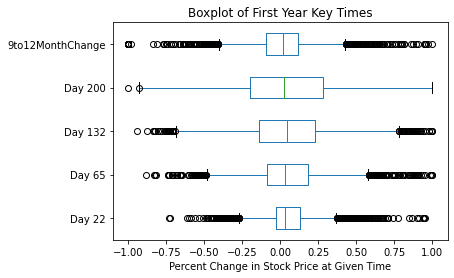

In [3]:
#Drop outliers, to visualize core portions of the data (there were mega outliers)
#so the data was hard to view in places where the majority of the information lay
dfBoxtemp = dfl.copy()
dfdropOut, uppbound = dfBoxtemp.copy(), 1
dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["Day 132"] > uppbound].index, inplace = True), dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["Day 22"] > uppbound].index, inplace = True), dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["Day 65"] > uppbound].index, inplace = True), dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["Day 200"] > uppbound].index, inplace = True), dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["Percent Change Day 0"] > uppbound].index, inplace = True), dfBoxtemp.drop( dfBoxtemp[dfBoxtemp["9to12MonthChange"] > uppbound].index, inplace = True)

#Plot performance from day 0 to month 9, along with the 9 to 12 month change in stock prices
dfBoxtemp.plot(kind='box', vert  = False,y=["Day 22","Day 65","Day 132","Day 200","9to12MonthChange"]), plt.xlabel("Percent Change in Stock Price at Given Time"), plt.title("Boxplot of First Year Key Times")
plt.show()

We see the variance of the change in price increases with time, while the median change in price is constant throughout. Thus the data center more or less does not change, while the variance in price changes. Hoever, the variance in price from month 9 to month 12 is just greater than the variance in price change for the first month for the IPO's. Thus, the price changes from month 9 to month 12 are about as stable as from day 0 to month 1, and more stable than day zero to month 3. We conclude IPO price stabilizes with time, asserting that the first 9 months may be a good predictor for performance in months 9 to 12.
######Now we will use random forests to identify which features have the largest impact on 9 to 12 month change in stock price.

In [4]:
#Set up variables
X, y = dfl.copy(), dfl["IsWinnerS"]
X = X.drop([main,"IsWinnerS","IsWinnerM","IsWinnerL"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
#Use a grid search to understand what RFC would be most useful for our data
forest = RandomForestClassifier(warm_start=True)
forest.fit(X_train,y_train)
pipe_param_grid = {"max_depth": [3,4,5,6,7], "max_features": [2,3,4,5,6], "n_estimators": [5,8,10,13,15,17]}
pipe_gs = GridSearchCV(forest,pipe_param_grid,n_jobs=-1,scoring="precision").fit(X_train,y_train)
print(pipe_gs.best_params_, pipe_gs.best_score_, sep='\n')

{'max_depth': 4, 'max_features': 5, 'n_estimators': 5}
0.6338095238095238


After 50 runs, I got multiple scores between .4 and .6338. The best features were max_depth=4, max_features=5, n_estimators=5.

In [ ]:
#Use RFC to understand which features are most important in understanding
#price changes in stocks from months 9 through 12
forestNew = RandomForestClassifier(warm_start=True,max_depth=4, max_features=5, n_estimators=5)
forestNew.fit(X_train,y_train)
importance = permutation_importance(forestNew, X_train, y_train)["importances_mean"]
features = sorted(zip(importance,X.columns),reverse=True)

#Print the top 10 features
print("Most important features: ")
for i in range(0,10):
  print(features[0:][i][1])

Most important features: 
Day 155
Day 185
MarketCap
Day 152
Day 146
volumeDay102
Day 170
volumeDay83
volumeDay189
volumeDay149


The majority of answers in the top 10 most important categories changes with each iteration. The only consistant features at the top of the list were MarketCap (usually in top 10), followed by DayBetterThanSP (usually in the top 20). Interestingly, on almost every iteration, after the first ~15 spots in the list, almost all 260 "VolumeDayX" features showed up in a row, followed by almost all of the categorical data, followed by almost all the "DayX" (referring to the price change on day X) features in a row. Thus on average, it appears daily trade volume is most important, followed by categorical information, followed by change in stock price on a given day. However, in the top 10 spots, ~6-8 "DayX" (reffering to price change on day X) features showed up, with only one or two "VolumeDayX" features. Thus, the top ten most important features usually regard some random days stock price changing, with few references to volume. Because of the inconsistancy, it is difficult to derive specific conclusions regarding important days, however it appears safe to say that on average, the daily trade volume for the majority of days is more important than most of the categorical data, followed by the stock price change by day. Further, MarketCap at 9 months and DaysBetterThanSP are strong categorical features for understanding performance of stocks in months 9 through 12. It is difficult to know how to use the information regarding the top 10 features mostly being random days stock price information, as one would need to very carefully build out a strategy to identify the EXACT days that are most important. The days tended to be in some ways clustered around certain times in the stocks lifecycle, but not uniformly in any sort of identifiable pattern that I could derive.
######Now, I will look at many iteration of initializing this random forest classifier, and look at it's predicted accuracy over time.

In [ ]:
#initialize varables to count outcomes
Truepos, Falsepos, other, runs = 0, 0, 0, 10

#Inspired by Monte Carlo Simulation, run a number of initializations of the
#RFC with best paramaters set, and see in the overall average how successful
#the RFC is in classifying our data
for i in range(0,runs):
  forestNew = RandomForestClassifier(warm_start=True,max_depth=4, max_features=5,n_estimators=5)
  forestNew.fit(X_train,y_train)
  arr = confusion_matrix(y_test,forestNew.predict(X_test))
  Truepos = Truepos + arr[1,1]
  Falsepos = Falsepos + arr[0,1]   
  other = other + arr[0,0]+arr[1,0] - arr[1,1] - arr[0,1]

#Print information
stringer = "On "+str(runs)+ " attemps we have:\n"
print(stringer, "True Positives: ", Truepos, "\n", "False Positives: ", Falsepos, "\n", "Other Outcomes: ",other)

On 10 attemps we have:
 True Positives:  9 
 False Positives:  24 
 Other Outcomes:  4994


Inspired by a Monte Carlo Simulation, I ran a number of scenarios to see on thousands of IPO's how successful we would potentially be using this RFC initialization, because it changed in outcome each time. Random Forest Classifiers were helpful in identifying on average what features to focus on, however do not appear to be a viable method overall for classifying successful stocks in this model. The precision here is 20%, well below our desired 50%. Further, even with 100% precision, this would yield only ~30 investmemnt opportunities over ~5000 IPO's which could take 10 - 30 years. Thus RFC are not strong enought to yield the results we desire.
######Now that we know DaysBetterThanSP and MarketCap are strong categorical features, we will plot them to look for any useful correlation.

In [ ]:
#@title
def density(dfscatplot,num,title):
  for i in range(0,2):
    x = dfscatplot.iloc[:,i]
    y = dfscattemp[main]
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    idx = z.argsort()
    x, y, z = x[idx],y[idx],z[idx]
    fig, ax = plt.subplots()
    ax.scatter(x,y,c=z,s=25,edgecolor="")
    plt.ylabel(main)
    plt.xlabel(df.columns[i])
    string = "Scatter of " + df.columns[i] + " Vs " + main + title
    plt.title(string)
    plt.show

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  # This is added back by InteractiveShellApp.init_path()


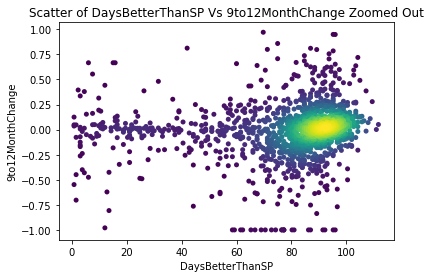

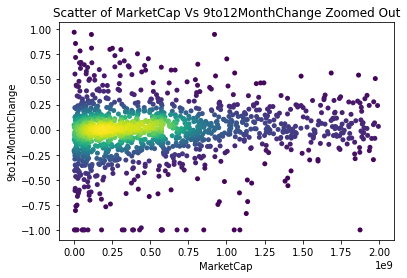

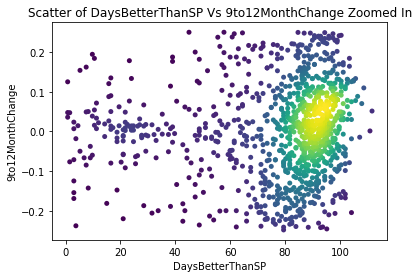

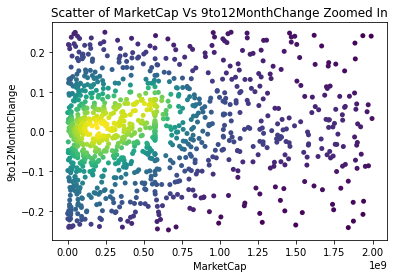

In [ ]:
dfscattemp = dfBoxtemp.copy()
dfscattemp.drop( dfscattemp[dfscattemp["MarketCap"] > 2000000000].index, inplace = True)
dfscatploter = dfscattemp.loc[:,["DaysBetterThanSP", "MarketCap"]]

#plot main features
density(dfscatploter,2," Zoomed Out")

#drop outliers in the y axis to see dense areas better, and plot
dfscattemp = dfBoxtemp.copy()
dfscattemp.drop( dfscattemp[dfscattemp["MarketCap"] > 2000000000].index, inplace = True), dfscattemp.drop( dfscattemp[dfscattemp[main] > .25].index, inplace = True), dfscattemp.drop( dfscattemp[dfscattemp[main] < -.25].index, inplace = True)
dfscatploter = dfscattemp.loc[:,["DaysBetterThanSP", "MarketCap", main]]
density(dfscatploter,2," Zoomed In")

In the "Zoomed Out" plots, it appears that both graphs follow an opposite pattern. One could almsot draw a horizontle asymptote at 0 on both plots, and a vertical asymptote at zero on the "MarketCap" plot, and a vertical asymptote at ~95 on the "DaysBetterThanSP" plot. The difficulty is looking at the zoomed out plots, they appear to mirror each other over the X axis, showing little indication of being a strong indicator for stock price changes in months 9 through 12, because it appears a stock is almost as likely to perform poorly as it is to perform well. Zooming in we have a similar pattern, except the "MarketCap" graph seems to have some sort of positive correlation from 0E+9 to .75E+9. We will try regrssing on this feature, as well as the larger set to find correlation.
######First regress on "MarketCap"



In [ ]:
#regression functions to tell us the R-squared value of our regression
def reggressor(dfFunc):
  XXX, y = dfFunc["MarketCap"], dfFunc[main]
  modelFriend = sm.regression.linear_model.OLS(y,XXX).fit()
  print("R-squared Value Regressing only on MarketCap: ", modelFriend.rsquared)
def reggressor2(dfFunc):
  XXX, y = dfFunc.loc[:,["MarketCap","DaysBetterThanSP"]], dfFunc[main]
  modelFriend = sm.regression.linear_model.OLS(y,XXX).fit()
  print("R-squared Value Regressign on MarketCap and DaysBetterThanSP: ", modelFriend.rsquared)

#Regression on MarketCap with no outliers dropped
reggressor(dfl)
#Regressing on MarketCap with outliers dropped,
reggressor(dfscattemp)
#Regressing on MarketCap and DaysBetterThanSP with outliers dropped
reggressor2(dfscatploter)

R-squared Value Regressing only on MarketCap:  0.0009823499197281205
R-squared Value Regressing only on MarketCap:  0.009821310910564596
R-squared Value Regressign on MarketCap and DaysBetterThanSP:  0.010007274644914799


Without dropping outliers, our R-squared value is .0009 which is terrible. With dropping outliers, our R-squared value is .009, which is a factor of 10 better, but still terrible. Regressing on "MarketCap" and "DaysBetterThanSP", we are at .01 which is still terrible. As expected, Market cap alone is probably not a great predictor of IPO performance, nor is market cap combined with days better than the S&P 500.
######Running regression on the whole data set yielded an R-squared value of ~.26, which is not great, but not terrible given the amount of variance in the stock market. However, we were vastly overfit. After trying a number of dimension reductions, PCA with 3 PCs resulted in 99.9% of the variance accounted for, and was the largest dimensionality I could work with that did not overfit the data. The following are the results.

In [ ]:
#Do PCA on our data
XX, y = X.copy(), dfl[main]
pca = PCA(n_components=3)
Xhat = pca.fit_transform(XX)

#Capture the explained variance
mat = pca.explained_variance_ratio_
val=0
for i in range(0,len(mat)):
  val = val + mat[i]
print("Percentage of variance explained with ", len(mat), " principle components: ", val)

#Run regression on our PCA model
modelpca = sm.regression.linear_model.OLS(y,Xhat).fit()
print("R-squared Value: ", modelpca.rsquared)

Percentage of variance explained with  3  principle components:  0.9999999427616272
R-squared Value:  0.0003839366092638352


With any more than 3 principle components, I was overfitting the data and needed regularization. 3 PCs also is representative of 99.999% of the variance in the data, and thus is sufficient to represent the greater population in this regression. However, we see that with 3 principle components, our R-squared value is .0003, which is terrible. Thus linear regression is not a viable method of predicing returns in our model.

In [ ]:
scanner = X.copy()
#Set up variables
X, y = dfl.copy(), dfl["IsWinnerS"]
X = X.drop([main,"IsWinnerS","IsWinnerM","IsWinnerL"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2)

In [ ]:
dbscan = DBSCAN(eps=.144, min_samples=6).fit(scanner)

R = np.zeros((2))
for i in range(len(scanner)):
  R[dbscan.labels_[i]]+=1
print(R)

predicted = dbscan.fit_predict(scanner)
print(predicted)

[   6. 2520.]
[-1 -1 -1 ... -1 -1 -1]
